# Generalized Lotka Volterra: joint alternate estimation for inverse problem

*Hugo Gangloff$^1$, Nicolas Jouvin$^1$, Lorenzo Sala$^2$ - December 2025*

$^1$ Université Paris-Saclay, AgroParisTech, INRAE UMR MIA Paris-Saclay, France

$^2$ Université Paris-Saclay, INRAE, MaIAGE, 78350, Jouy-en-Josas, France 

<div class="alert alert-block alert-info">
<b>Abstract</b>: In this notebook we jointly estimate the equation solution with a PINN and the equation parameter $\theta$. We will also make use of available observations and we will also differentiate the dynamic loss with respect to the equation parameter $\theta$.
</div>

**Outline**

1. [Mathematical background](#Mathematical-background)
2. [Code set-up](#Code-set-up)
3. [Joint alternate training (simple)](#Joint-alternate-training-(simple))
4. [Joint alternate training (regularized)](#Joint-alternate-training-(regularized))
5. [Vanilla joint training](#Vanilla-joint-training)
6. [Vanilla joint training (regularized)](#Vanilla-joint-training-(regularized))
7. [Comparison of the approaches](#Comparison-of-the-approaches)
8. [Comparison with mean-square solver](#Comparison-with-mean-square-solver)

## Mathematical background

On the time interval $I=[0, T]$, we consider a **Generalized Lotka Volterra** system with $N_s$ populations, $\forall t\in I$, where $x_i(t)$ denotes the abundance (biomass) of species $i$ at time $t$:

$$
\frac{dx_i(t)}{dt} = \mu_i x_i(t) + \sum_{j=1}^{N_s} a_{ij} x_i(t) x_j(t), 
\quad i = 1, \dots, N_s,
$$

where $\mu_i$ are the growth rates and $a_{ij}$ are the interactions terms. We also have some initial conditions $x_i(0) = x_{i,0} > 0$.

We will work with the GLV equation in logarithmic (for stability and positiveness) and vectorial form (for concision):

$$
\frac{du(t)}{dt} = \mu + A \exp(u(t)),
$$
where $u(t) = (\log x_1(t), \dots, \log x_{N_s}(t))^\top$, 
$\mu = (\mu_1, \dots, \mu_{N_s})^\top$, 
and $A = (a_{ij})_{1 \le i,j \le N_s}$. We denote the equation parameters as $\theta=\{\mu, A\}$.

We are working in the context of **inverse problem**, *i.e.* we have at our disposal **noisy observations of the solution** at some sampled times $\{t_j, u_j\}_{j=1}^{n_o}$ that we will use to estimate both the solution $u$ and the parameters $\theta$. We work the in the **PINN methodology**, we approximate the solution as a neural network $u_\nu : I \mapsto \mathbb{R}^{N_s}$, where $\nu$ are the weights and biases of the neural network that we need to estimate.


Therefore, we aim at solving:

$$
\hat{\nu},\hat{\theta}=\arg\min_{\nu,\theta} \mathcal{L}(\nu,\theta)
$$
with the loss:

$$
\begin{align*}
\mathcal{L}(\nu,\theta)&=\frac{1}{n_c} \sum_{i=1}^{n_c} \Vert \frac{du_\nu(t_i)}{dt} - \mu - A \exp(u_\nu(t_i))\Vert^2 + \Vert u_\nu(0) - u_0 \Vert_2^2\\
&+\frac{1}{n_o} \sum_{j=1}^{n_o} \Vert u_\nu(t_j) - u_j \Vert^2,
\end{align*}
$$

where $\{t_i\}_{i=1}^{i=n_c}$ is a set of randomly selected collocation points and $u_0=(\log x_{1, 0}, \dots, \log x_{N_s,0})$ is the vector of initial condition values.

More precisely, [Section 3](#Joint-alternate-training-(simple)) and [Section 4](#Joint-alternate-training-(regularized)) will consider a coordinate descent on the problem above, namely, an alternate optimization between $\nu$ and $\theta=\{\mu,A\}$ will be set up.

- The optimization scheme for step $n+1$ can then be written for [Section 3](#Joint-alternate-training-(simple)):

$$
\begin{align*}
        \{\mu,A\}^{[n+1]} & \leftarrow \arg\min_{\{\mu,A\}} \frac{1}{n_c} \sum_{i=1}^{n_c} \Vert \frac{du_{\nu^{[n]}}(t_i)}{dt} - \mu - A \exp(u_{\nu^{[n]}}(t_i))\Vert^2 \\
        \nu^{[n+1]} & \leftarrow \arg\min_{\nu} \mathcal{L}(\nu,\{\mu,A\}^{[n+1]}).
\end{align*}
$$

- The optimization scheme for step $n+1$ can then be written for [Section 4](#Joint-alternate-training-(regularized)):

$$
\begin{align*}
        \{\mu,A\}^{[n+1]} & \leftarrow \arg\min_{\{\mu,A\}} \frac{1}{n_c} \sum_{i=1}^{n_c} \Vert \frac{du_{\nu^{[n]}}(t_i)}{dt} - \mu - A \exp(u_{\nu^{[n]}}(t_i))\Vert^2 + \lambda_\theta \Vert \theta \Vert_1  \\
        \nu^{[n+1]} & \leftarrow \arg\min_{\nu} \mathcal{L}(\nu,\{\mu,A\}^{[n+1]}) + \lambda_\nu \Vert\nu\Vert^2_2,
\end{align*}
$$

where we added a lasso penalization on the coefficients $\theta$ and a ridge regularization on $\nu$.

On the other hand, [Section 5](#Vanilla-joint-training) and [Section 6](#Vanilla-joint-training-(regularized)) will perform a direct joint optimization on both set of parameters.

- The optimization problem can then be written for [Section 5](#Vanilla-joint-training):

$$
\hat{\nu},\hat{\theta} = \arg\min_{\nu,\theta} \mathcal{L}(\nu,\theta).
$$

- The optimization problem can then be written for [Section 6](#Vanilla-joint-training-(regularized)):

$$
\hat{\nu},\hat{\theta} = \arg\min_{\nu,\theta} \mathcal{L}(\nu,\theta) + \lambda_\nu \Vert\nu\Vert^2_2  + \lambda_\theta \Vert \theta \Vert_1.
$$

**Initialization**: in all cases:

- $\theta$ is initialization to the $0$ of its vector space.

- $\nu$ parameters are first initialized with `equinox` default initialization for weight and biaises in linear layers. However a **pretraining on data only** is performed for all optimization problems, serving as a "warm-up" for the neural network. That is the joint optimizations all begin with a $\nu^{ini}$ such that:

$$
\nu^{ini} = \arg\min_{\nu} \frac{1}{n_o} \sum_{j=1}^{n_o} \Vert u_\nu(t_j) - u_j \Vert^2
$$

- we use projected gradient descent to enforce some constraints:
  - $\mu\in(\mathbb{R}^+)^{N_s}$
  - $A_{i,i}\in\mathbb{R}^-, \forall i\in\{1, N_s\}$

## Code set-up

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
import jinns

Import other dependencies

In [3]:
import jax

# from jax import config
# config.update("jax_enable_x64", True)
import jax.numpy as jnp
import optax
import equinox as eqx
import matplotlib.pyplot as plt

figsize = (4, 4)
plt.rcParams["figure.figsize"] = figsize

In [ ]:
# Find out which device (GPU vs CPU) JAX is currently using for computations.
# For GPU, you need to install JAX+GPU prior to jinns
# see https://docs.jax.dev/en/latest/installation.html
jax.devices()

In [4]:
key = jax.random.PRNGKey(0)

W1215 10:11:39.001201   20369 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1215 10:11:39.004505   20264 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


### Define the equation parameters

Time domain

In [5]:
tmin = 0
tmax = 1

Tmax = 200

In [6]:
# initial conditions for each species

### 10 population example
key, subkey = jax.random.split(key)

Ns = 10
A = jax.random.normal(subkey, shape=(Ns, Ns)) * 1e-2
key, subkey = jax.random.split(key)
dA = jnp.diag(A)
key, subkey = jax.random.split(key)
A *= jax.random.bernoulli(subkey, p=0.4, shape=A.shape)
A = A - A.T
A = A + jnp.diag(-jnp.abs(dA))
interactions = A
key, subkey = jax.random.split(key)
growth_rates = jnp.abs(jax.random.normal(subkey, shape=(Ns,))) * 1e-1
key, subkey = jax.random.split(key)
N_0 = jax.random.uniform(subkey, shape=(Ns,)) * 10

In [7]:
key, subkey = jax.random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(
    key=subkey,
    nt=500,
    tmin=tmin,
    tmax=tmax,
    method="uniform",
    temporal_batch_size=None,
)

ts = val_data.times.sort(axis=0).squeeze()
# NOTE parfois np.any(np.diff(ts) <= 0) qui provoque une erreur dans solve_ivp
# mais on a toujours np.any(np.diff(ts) < 0)

### Observations

We use observations obtained from a run of a ground truth solver/

In [8]:
import numpy as np
from scipy.integrate import solve_ivp


def GLV_RHS(t, y, theta):
    """
    This equation is written in log space. That means the input y is the logarithm of the population density
    """
    alpha, gamma = theta[0], theta[1]
    return (alpha + (gamma @ jnp.exp(y).reshape((gamma.shape[0], 1))).squeeze()).ravel()


# Define model parameters
eq_params = (growth_rates, interactions)

# Define initial bacterial populations
y0 = N_0

# Define time points
t = ts * Tmax

############################

y0_log = np.log(y0)
sol_log = solve_ivp(
    fun=GLV_RHS,
    y0=y0_log,
    t_span=(0, Tmax),
    t_eval=ts * Tmax,
    args=(eq_params,),
)
y = np.exp(sol_log.y).T

In [11]:
n = 500
subsample_size = 10
subsample = jnp.arange(n)
subsample = subsample[:: int(n / (subsample_size - 1))]
subsample = jnp.append(subsample[:-1], n - 1)

# key, subkey = jax.random.split(key)
# subsample = jnp.sort(
#    jax.random.choice(subkey, n - 3, shape=(subsample_size - 2,), replace=False) + 1
# ).astype(jnp.int16)
# subsample = jnp.append(jnp.array([0]), subsample)
# subsample = jnp.append(subsample, n - 1)

t_subsample = ts[subsample]
log_obs_subsample = jnp.log(y[subsample])

__We then add a Gaussian noise (in log-space)__

The noise model is $\log y_i = \log y^\star(t_i) + \epsilon_i$ with Gaussian noise of variance $\sigma^2$. 

In [13]:
noise_level = 0.2

key, subkey = jax.random.split(key)
noise = noise_level * jax.random.normal(subkey, shape=log_obs_subsample.shape)
log_obs_subsample_noisy = log_obs_subsample + noise
# obs_subsample_noisy = jnp.where(obs_subsample_noisy < 1e-6, 1e-6, obs_subsample_noisy)

**Visualize the noisy observations**

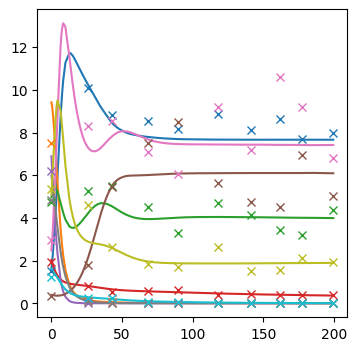

In [14]:
plt.plot(ts * Tmax, y, "-")
plt.gca().set_prop_cycle(None)
plt.plot(t_subsample * Tmax, jnp.exp(log_obs_subsample_noisy), "x")
plt.show()

### Estimate the solution and the parameters of the GLV system

*Define the domain and the associated data generator*

In [15]:
key, subkey = jax.random.split(key)
train_data = jinns.data.DataGeneratorODE(
    key=subkey,
    nt=5000,
    tmin=tmin,
    tmax=tmax,
    temporal_batch_size=None,
    method="uniform",
)

*Define the data generator for the observations*

In [16]:
key, subkey = jax.random.split(key)
obs_data = jinns.data.DataGeneratorObservations(
    key=subkey,
    obs_batch_size=None,
    observed_pinn_in=t_subsample,
    observed_values=log_obs_subsample_noisy,
)

*Define the PINN*

Create the neural network architecture for the PINN with `equinox`.

In [17]:
N_neurons = 7 * Ns
eqx_list = (
    (eqx.nn.Linear, 1, Ns),
    (jax.nn.tanh,),
    (eqx.nn.Linear, Ns, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, Ns),
    (jax.nn.tanh,),
    (eqx.nn.Linear, Ns, Ns),
)
key, subkey = jax.random.split(key)
u, init_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="ODE"
)

*Define the jinns parameter object. **Equation parameters are initialized to 0 everywhere.***

In [18]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "g": jnp.zeros_like(growth_rates),
        "i": jnp.zeros_like(interactions),
    },
)

*Define the loss weights*

In [19]:
loss_weights = jinns.loss.LossWeightsODE(
    dyn_loss=1.0 / Tmax, initial_condition=1.0, observations=1.0
)

*Define the dynamic loss term*

In [20]:
class GLV_loss(jinns.loss.ODE):
    def equation(self, t, u, params):
        """
        This equation is given in log, this means that u is the log of the population density
        """
        udt = jax.jacfwd(lambda x: u(x, params))(t).squeeze()
        f = udt - self.Tmax * GLV_RHS(
            t, u(t, params), (params.eq_params.g, params.eq_params.i)
        )
        return f


dynamic_loss = GLV_loss(Tmax=Tmax)

*Define how to differentiate each term of the loss* Note that the main `params` of the problem must be passed since we use the `from_str()` constructor

In [21]:
derivative_keys = jinns.parameters.DerivativeKeysODE.from_str(
    dyn_loss=jinns.parameters.Params(
        nn_params=True,
        eq_params={
            "g": jax.tree.map(lambda _: True, init_params.eq_params.g),
            "i": jax.tree.map(lambda _: True, init_params.eq_params.i),
        },
    ),
    initial_condition="nn_params",
    observations="nn_params",
    params=init_params,
)

*Define the ODE PINN losses*

In [22]:
loss = jinns.loss.LossODE(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=dynamic_loss,
    initial_condition=(float(tmin), jnp.log(y0)),
    derivative_keys=derivative_keys,
    params=init_params,
)

*We will start with a PINN pretraining on observations only. One argument in favor of such pretraining is  to avoid $\theta$ collapsing to $0$. All approaches that will follow will benefit from this pretraining.*

**Pretraining**

In [23]:
pretrain_loss_weights = jinns.loss.LossWeightsODE(
    dyn_loss=0.0,
    initial_condition=1.0,
    observations=1.0,  # ZERO to block gradients from dynamic loss
)
pretrain_loss = jinns.loss.LossODE(
    u=u,
    loss_weights=pretrain_loss_weights,
    dynamic_loss=dynamic_loss,
    initial_condition=(float(tmin), jnp.log(y0)),
    derivative_keys=derivative_keys,
    params=init_params,
)

In [24]:
pretrain_tx = optax.adam(learning_rate=1e-3)

key, subkey = jax.random.split(key)
print("PINN pretraining with observations only")
(
    pretrain_params,
    total_loss_values,
    loss_by_term_dict,
    _,
    _,
    _,
    _,
    stored_loss_weight_terms,
    _,
    _,
    _,
    _,
) = jinns.solve(
    n_iter=10000,
    init_params=init_params,
    data=train_data,
    optimizer=pretrain_tx,
    loss=pretrain_loss,
    obs_data=obs_data,
    print_loss_every=1000,
    key=subkey,
)

PINN pretraining with observations only
Initialization time: 0.548616886138916

Compilation took
 5.996939182281494 

[train] Iteration 0: loss value = 1053.4600830078125
[train] Iteration 1000: loss value = 758.7393798828125
[train] Iteration 2000: loss value = 399.7953796386719
[train] Iteration 3000: loss value = 112.68185424804688
[train] Iteration 4000: loss value = 40.46836471557617
[train] Iteration 5000: loss value = 13.993186950683594
[train] Iteration 6000: loss value = 4.7279887199401855
[train] Iteration 7000: loss value = 1.542669415473938
[train] Iteration 8000: loss value = 0.39510446786880493
[train] Iteration 9000: loss value = 0.1444374918937683

Stopping main optimization loop, cause: max iteration is reached

Training took
 44.996777057647705 


Final iteration 10000: train loss value = 0.10587406903505325


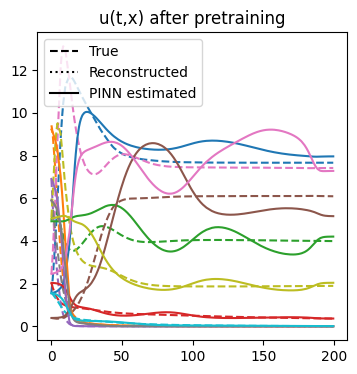

In [ ]:
from matplotlib.lines import Line2D

pretrain_u_est = jax.vmap(lambda t_x: jnp.exp(u(t_x, pretrain_params)))

plt.plot(ts * Tmax, y, linestyle="--", label="True")
plt.gca().set_prop_cycle(None)
plt.plot(ts * Tmax, pretrain_u_est(ts), label="PINN estimated")
# plt.plot(t_subsample * Tmax, jnp.exp(log_obs_subsample_noisy), 'x')
plt.title("u(t,x) after pretraining")
legend_elements = [
    Line2D([0], [0], color="k", linestyle="--", label="True"),
    Line2D([0], [0], color="k", label="PINN estimated"),
]
# Create the figure
plt.legend(handles=legend_elements, loc="upper left")
plt.show()

In [26]:
assert jnp.allclose(
    total_loss_values,
    loss_by_term_dict.observations * pretrain_loss_weights.observations
    + loss_by_term_dict.initial_condition * pretrain_loss_weights.initial_condition,
)  # check that we only use observations and initial conditions

**The next cell defines the number of iterations and is common to all the methods, with a slight adaptation for the non alternate methods**

In [27]:
# number of alternate iterations
n_iter = 300
# number of iterations for each solver
n_iter_by_solver = jinns.parameters.Params(
    nn_params=250,
    eq_params={"g": 250, "i": 250},
)

### Joint alternate training (simple)

**with `jinns.solve_alternate()`**

*We will need to construct the object needed for the `jinns.solve_alternate()` call.*

**Alternate joint estimation**

In [28]:
from functools import partial
from utils_GLV_JointEstimation_Alternate import update_and_project

update_and_project_g = partial(update_and_project, param="g")
update_and_project_i = partial(update_and_project, param="i")

In [29]:
start_learning_rate = 1e-3


# solver for each set of parameters
optimizers = jinns.parameters.Params(
    nn_params=optax.adamw(learning_rate=start_learning_rate),
    eq_params={
        "g": optax.chain(
            optax.adam(learning_rate=start_learning_rate),
            update_and_project_g(),
        ),
        "i": optax.chain(
            optax.adam(learning_rate=1e-6),
            update_and_project_i(),
        ),
    },
)

*We now start the alternate training*

In [30]:
(
    params_alternate,
    total_loss_values,
    loss_by_term_dict,
    _,
    _,
    _,
    stored_params,
    stored_loss_weight_terms,
    _,
    _,
) = jinns.solve_alternate(
    n_iter=n_iter,
    n_iter_by_solver=n_iter_by_solver,
    init_params=pretrain_params,
    data=train_data,
    loss=loss,  # take the complete loss!
    optimizers=optimizers,
    verbose=True,
    obs_data=obs_data,
    key=subkey,
    print_loss_every=20,
)

Initialization time: 8.740840435028076
[train alternate]Iteration 0: loss value = 14.30458927154541
[train alternate]Iteration 20: loss value = 1.773679256439209
[train alternate]Iteration 40: loss value = 0.3260083794593811
[train alternate]Iteration 60: loss value = 0.14431914687156677
[train alternate]Iteration 80: loss value = 0.11294306069612503
[train alternate]Iteration 100: loss value = 0.10524449497461319
[train alternate]Iteration 120: loss value = 0.09030082076787949
[train alternate]Iteration 140: loss value = 0.08399449288845062
[train alternate]Iteration 160: loss value = 0.0917900875210762
[train alternate]Iteration 180: loss value = 0.07707735896110535
[train alternate]Iteration 200: loss value = 0.07414938509464264
[train alternate]Iteration 220: loss value = 0.07095618546009064
[train alternate]Iteration 240: loss value = 0.06884725391864777
[train alternate]Iteration 260: loss value = 0.06654299795627594
[train alternate]Iteration 280: loss value = 0.0757873356342315

**Results**

*Plot the loss values*

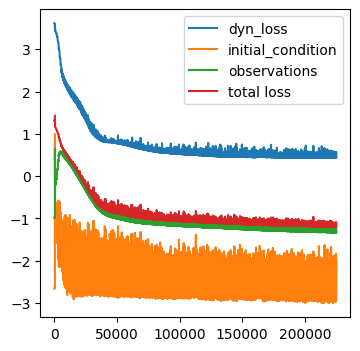

In [31]:
for loss_name, loss_values in loss_by_term_dict.items():
    # if loss_name == "observations":
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_values), label="total loss")
plt.legend()
plt.show()

### Joint alternate training (regularized)

**with `jinns.solve_alternate()`**

In [32]:
from utils_GLV_JointEstimation_Alternate import soft_thresholding_additive_update

soft_thresholding_additive_update_g = partial(
    soft_thresholding_additive_update, param="g"
)
soft_thresholding_additive_update_i = partial(
    soft_thresholding_additive_update, param="i"
)

In [33]:
# solver for each set of parameters
optimizers = jinns.parameters.Params(
    nn_params=optax.adamw(learning_rate=1e-3),
    eq_params={
        "g": optax.chain(
            optax.sgd(learning_rate=1e-3),
            soft_thresholding_additive_update_g(learning_rate=1e-3, l1reg=None),
        ),
        "i": optax.chain(
            optax.sgd(learning_rate=1e-6),
            soft_thresholding_additive_update_i(learning_rate=1e-6, l1reg=1e-3),
        ),
    },
)

In [34]:
(
    params_alternate_regularized,
    total_loss_values,
    loss_by_term_dict,
    _,
    _,
    _,
    stored_params,
    stored_loss_weight_terms,
    _,
    _,
) = jinns.solve_alternate(
    n_iter=n_iter,
    n_iter_by_solver=n_iter_by_solver,
    init_params=init_params,  # pretrain_params,
    data=train_data,
    loss=loss,  # take the complete loss!
    optimizers=optimizers,
    verbose=True,
    obs_data=obs_data,
    key=subkey,
    print_loss_every=20,
)

Initialization time: 5.767456769943237
[train alternate]Iteration 0: loss value = 862.316650390625
[train alternate]Iteration 20: loss value = 12.623871803283691
[train alternate]Iteration 40: loss value = 0.29158055782318115
[train alternate]Iteration 60: loss value = 0.19118955731391907
[train alternate]Iteration 80: loss value = 0.15773651003837585
[train alternate]Iteration 100: loss value = 0.14256879687309265
[train alternate]Iteration 120: loss value = 0.13530124723911285
[train alternate]Iteration 140: loss value = 0.13146547973155975
[train alternate]Iteration 160: loss value = 0.12437571585178375
[train alternate]Iteration 180: loss value = 0.1208978220820427
[train alternate]Iteration 200: loss value = 0.12508368492126465
[train alternate]Iteration 220: loss value = 0.11505017429590225
[train alternate]Iteration 240: loss value = 0.10695207118988037
[train alternate]Iteration 260: loss value = 0.10634463280439377
[train alternate]Iteration 280: loss value = 0.110431186854839

**Results**

*Plot loss values*

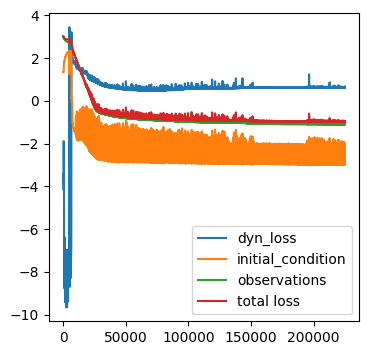

In [35]:
for loss_name, loss_values in loss_by_term_dict.items():
    # if loss_name == "observations":
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_values), label="total loss")
plt.legend()
plt.show()

### Vanilla joint training

**with `jinns.solve()`**

**Loss for `jinns.solve()`**

In [36]:
loss = jinns.loss.LossODE(
    u=u,
    loss_weights=jinns.loss.LossWeightsODE(
        dyn_loss=1.0,
        initial_condition=1.0,
        observations=1.0,
    ),
    dynamic_loss=dynamic_loss,
    initial_condition=(float(tmin), jnp.log(y0)),
    derivative_keys=derivative_keys,
    params=init_params,
)

In [37]:
from functools import partial
from utils_GLV_JointEstimation_Alternate import update_and_project

update_and_project_g = partial(update_and_project, param="g")
update_and_project_i = partial(update_and_project, param="i")

param_labels = jinns.parameters.Params(
    nn_params="nn_adam",  # in this simple example we will use adamw for the nu
    eq_params={
        "g": "g_adam",
        "i": "i_adam",
    },  # in this simple example we will use rprop for theta
)

tx_nu_and_theta = optax.multi_transform(
    {
        "nn_adam": optax.adamw(learning_rate=1e-3),
        "g_adam": optax.chain(
            optax.adam(learning_rate=1e-3),
            update_and_project_g(),
        ),
        "i_adam": optax.chain(
            optax.adam(learning_rate=1e-6),
            update_and_project_i(),
        ),
    },  # all the keys in this dict must be found as leaves in the PyTree param_labels
    param_labels,
)

key, subkey = jax.random.split(key, 2)
n_iter_nu_and_theta = (n_iter * sum(jax.tree.leaves(n_iter_by_solver))) // (
    len(jax.tree.leaves(n_iter_by_solver))
)

In [38]:
params_vanilla, total_loss_values, loss_by_term_dict, _, _, _, _, _, _, _, _, _ = (
    jinns.solve(
        init_params=pretrain_params,
        data=train_data,
        optimizer=tx_nu_and_theta,
        loss=loss,
        n_iter=n_iter_nu_and_theta,
        obs_data=obs_data,
        print_loss_every=10000,
    )
)

Initialization time: 0.22326016426086426

Compilation took
 2.9526023864746094 

[train] Iteration 0: loss value = 4105.4072265625
[train] Iteration 10000: loss value = 8.545742988586426
[train] Iteration 20000: loss value = 2.2948122024536133
[train] Iteration 30000: loss value = 0.9433611631393433
[train] Iteration 40000: loss value = 0.6026453971862793
[train] Iteration 50000: loss value = 0.5129685401916504
[train] Iteration 60000: loss value = 0.39977723360061646
[train] Iteration 70000: loss value = 0.29695338010787964

Stopping main optimization loop, cause: max iteration is reached

Training took
 343.2548439502716 


Final iteration 75000: train loss value = 0.2880145311355591


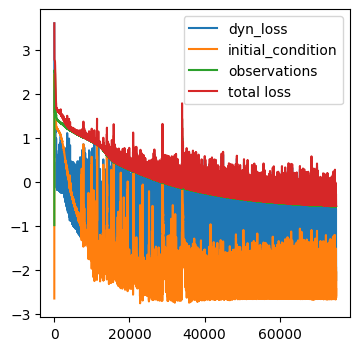

In [39]:
for loss_name, loss_values in loss_by_term_dict.items():
    # if loss_name == "observations":
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_values), label="total loss")
plt.legend()
plt.show()

### Vanilla joint training (regularized)

**with `jinns.solve()`**

Here we decrease the learning rates for `eq_params`, otherwise we get exploding gradients.

In [40]:
from functools import partial
from utils_GLV_JointEstimation_Alternate import update_and_project

update_and_project_g = partial(update_and_project, param="g")
update_and_project_i = partial(update_and_project, param="i")

param_labels = jinns.parameters.Params(
    nn_params="nn_adam",  # in this simple example we will use adamw for the nu
    eq_params={
        "g": "g_prox",
        "i": "i_prox",
    },  # in this simple example we will use rprop for theta
)

tx_nu_and_theta = optax.multi_transform(
    {
        "nn_adam": optax.adamw(learning_rate=1e-3),
        "g_prox": optax.chain(
            optax.sgd(learning_rate=1e-5),
            soft_thresholding_additive_update_g(learning_rate=1e-5, l1reg=None),
        ),
        "i_prox": optax.chain(
            optax.sgd(learning_rate=1e-8),
            soft_thresholding_additive_update_i(learning_rate=1e-8, l1reg=1e-8),
        ),
    },  # all the keys in this dict must be found as leaves in the PyTree param_labels
    param_labels,
)

key, subkey = jax.random.split(key, 2)
n_iter_nu_and_theta = (n_iter * sum(jax.tree.leaves(n_iter_by_solver))) // (
    len(jax.tree.leaves(n_iter_by_solver))
)

In [41]:
(
    params_vanilla_regularized,
    total_loss_values,
    loss_by_term_dict,
    _,
    _,
    _,
    _,
    _,
    _,
    _,
    _,
    _,
) = jinns.solve(
    init_params=pretrain_params,
    data=train_data,
    optimizer=tx_nu_and_theta,
    loss=loss,
    n_iter=n_iter_nu_and_theta,
    obs_data=obs_data,
    print_loss_every=10000,
)

Initialization time: 0.1946885585784912

Compilation took
 2.6984074115753174 

[train] Iteration 0: loss value = 4105.4072265625
[train] Iteration 10000: loss value = 1.0060920715332031
[train] Iteration 20000: loss value = 0.5926718711853027
[train] Iteration 30000: loss value = 0.5078400373458862
[train] Iteration 40000: loss value = 0.4483732283115387
[train] Iteration 50000: loss value = 0.4747164845466614
[train] Iteration 60000: loss value = 0.7975574731826782
[train] Iteration 70000: loss value = 0.3558609187602997

Stopping main optimization loop, cause: max iteration is reached

Training took
 343.59798526763916 


Final iteration 75000: train loss value = 0.5602685213088989


*Errors on parameters*

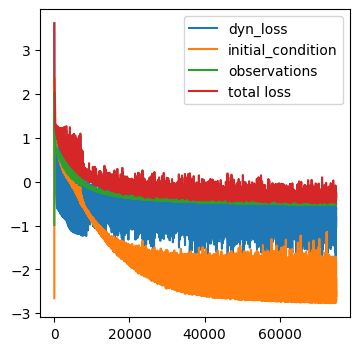

In [42]:
for loss_name, loss_values in loss_by_term_dict.items():
    # if loss_name == "observations":
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_values), label="total loss")
plt.legend()
plt.show()

## Comparison of the approaches

### Error on parameters

In [43]:
from dataclasses import fields


def errors_on_parameters(true, estimated):
    return_dict = {}
    for f in fields(estimated.eq_params):
        p = getattr(estimated.eq_params, f.name)
        p_true = getattr(true, f.name)
        rmse = jnp.sqrt(jnp.mean((p - p_true) ** 2))
        return_dict[f.name] = rmse.item()
    return return_dict

In [44]:
from jinns.parameters import EqParams

true_params = EqParams({"g": growth_rates, "i": interactions})

rmse_parameters_alternate = errors_on_parameters(true_params, params_alternate)
rmse_parameters_alternate_regularized = errors_on_parameters(
    true_params, params_alternate_regularized
)
rmse_parameters_vanilla = errors_on_parameters(true_params, params_vanilla)
rmse_parameters_vanilla_regularized = errors_on_parameters(
    true_params, params_vanilla_regularized
)

In [45]:
import pandas as pd

df_error_parameters = pd.DataFrame.from_dict(
    {
        "Alternate": rmse_parameters_alternate,
        "Alternate (l1-regularized)": rmse_parameters_alternate_regularized,
        "Vanilla": rmse_parameters_vanilla,
        "Vanilla (regularized)": rmse_parameters_vanilla_regularized,
    }
)

df_error_parameters.T

,g,i
Alternate,0.104957,0.017623
Alternate (l1-regularized),0.092752,0.009957
Vanilla,0.077557,0.007859
Vanilla (regularized),0.080386,0.007606


### Errors on the curves

In [46]:
def error_on_the_curves(y, pinn_estimated_function, params_estimated):
    """
    y: true curves
    """
    # Profiled error: RMSE error between the true curve and the PINN estimation
    rmse_p = jnp.sum(
        jax.vmap(lambda y, y_: jnp.mean((y - y_) ** 2), (1, 1))(
            y, pinn_estimated_function(ts)
        )
    )
    # print("RMSE profiled error", rmse_p)

    # Reconstructed error: RMSE error between the true curve and the ground truth solver solution run
    # with the system parameters estimated by jinns.solve_alternate()
    rec_sol_log = solve_ivp(
        fun=GLV_RHS,
        y0=y0_log,
        t_span=(0, Tmax),
        t_eval=ts * Tmax,
        args=(
            (
                params_estimated.eq_params.g,
                params_estimated.eq_params.i,
            ),
        ),
    )
    rec_y = np.exp(rec_sol_log.y).T
    rmse_r = jnp.sum(jax.vmap(lambda y, y_: jnp.mean((y - y_) ** 2), (1, 1))(y, rec_y))
    # print("RMSE profiled error", rmse_r)

    rmse_curves = {"profiled": rmse_p.item(), "reconstructed": rmse_r.item()}
    return rmse_curves, rec_sol_log

In [47]:
trained_u_est_alternate = jax.vmap(lambda t_x: jnp.exp(u(t_x, params_alternate)))
trained_u_est_alternate_regularized = jax.vmap(
    lambda t_x: jnp.exp(u(t_x, params_alternate_regularized))
)
trained_u_est_vanilla = jax.vmap(lambda t_x: jnp.exp(u(t_x, params_vanilla)))
trained_u_est_vanilla_regularized = jax.vmap(
    lambda t_x: jnp.exp(u(t_x, params_vanilla_regularized))
)


rmse_curves_alternate, rec_sol_log_alternate = error_on_the_curves(
    y, trained_u_est_alternate, params_alternate
)
rmse_curves_alternate_regularized, rec_sol_log_alternate_regularized = (
    error_on_the_curves(
        y, trained_u_est_alternate_regularized, params_alternate_regularized
    )
)
rmse_curves_vanilla, rec_sol_log_vanilla = error_on_the_curves(
    y, trained_u_est_vanilla, params_vanilla
)
rmse_curves_vanilla_regularized, rec_sol_log_vanilla_regularized = error_on_the_curves(
    y, trained_u_est_vanilla_regularized, params_vanilla_regularized
)

In [48]:
df_error_trajectories = pd.DataFrame.from_dict(
    {
        "Alternate": rmse_curves_alternate,
        "Alternate (l1-regularized)": rmse_curves_alternate_regularized,
        "Vanilla": rmse_curves_vanilla,
        "Vanilla (regularized)": rmse_curves_vanilla_regularized,
    }
)

df_error_trajectories.T.rename(columns=lambda name: name.capitalize())

,Profiled,Reconstructed
Alternate,10.068593,9.007326
Alternate (l1-regularized),6.531587,5.946885
Vanilla,17.593184,17.927315
Vanilla (regularized),10.884895,10.918575


In [49]:
from matplotlib.lines import Line2D


def plot_curves(title, rec_sol_log, pinn_estimated_function):
    plt.plot(ts * Tmax, y)
    plt.gca().set_prop_cycle(None)
    if rec_sol_log.status == 0:
        rec_y = np.exp(rec_sol_log.y).T
        plt.plot(ts * Tmax, rec_y, linestyle="dotted", label="Reconstructed")
    else:
        print(
            "Warning! Curves from scipy solver with estimated parameters are not plotted because a problem appeared in the resolution"
        )
    plt.gca().set_prop_cycle(None)
    plt.plot(
        ts * Tmax, pinn_estimated_function(ts), linestyle="--", label="PINN estimated"
    )
    plt.gca().set_prop_cycle(None)
    plt.plot(t_subsample * Tmax, jnp.exp(log_obs_subsample_noisy), "x")
    plt.title(title)
    legend_elements = [
        Line2D([0], [0], color="k", label="True"),
        Line2D([0], [0], color="k", linestyle="dotted", label="Reconstructed"),
        Line2D([0], [0], color="k", linestyle="--", label="PINN estimated"),
        Line2D([0], [0], color="k", marker="x", linestyle="none", label="Observations"),
    ]
    # Create the figure
    plt.legend(handles=legend_elements, loc="upper left")
    plt.show()

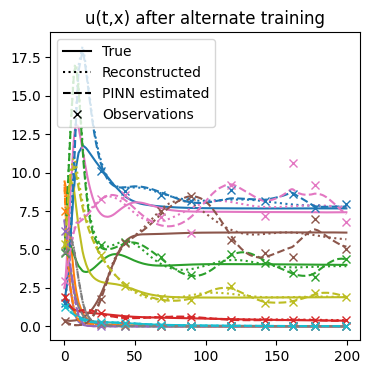

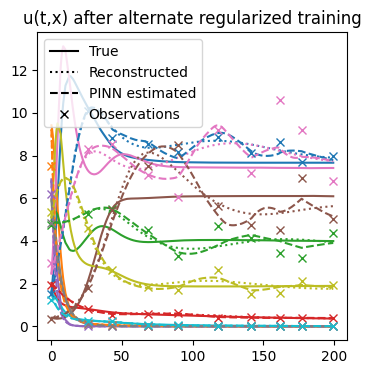

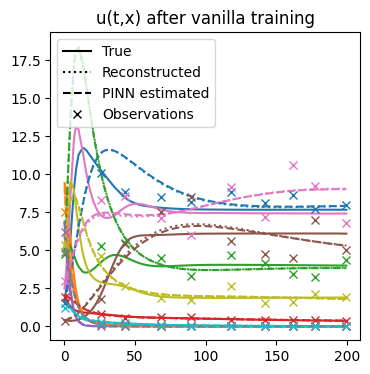

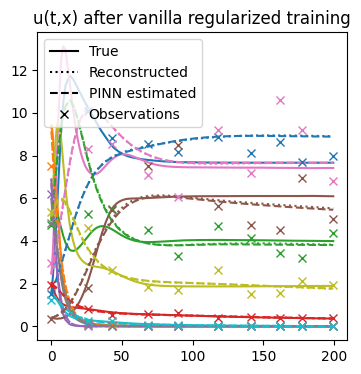

In [50]:
plot_curves(
    "u(t,x) after alternate training", rec_sol_log_alternate, trained_u_est_alternate
)
plot_curves(
    "u(t,x) after alternate regularized training",
    rec_sol_log_alternate_regularized,
    trained_u_est_alternate_regularized,
)
plot_curves("u(t,x) after vanilla training", rec_sol_log_vanilla, trained_u_est_vanilla)
plot_curves(
    "u(t,x) after vanilla regularized training",
    rec_sol_log_vanilla_regularized,
    trained_u_est_vanilla_regularized,
)

## Comparison with mean-square solver

> Adapted from the [Optimising a parameterised ODE tutorial of Optimistix](https://docs.kidger.site/optimistix/examples/optimise_diffeq/)

This part needs the additional dependencies to run
 1. `Diffrax` 
 2. `Optimistix`
 3. `jaxtyping` (for type hint)

Here's an example in which we optimise the parameters of an ODE. This means we have a differential equation solve inside our nonlinear solve! Precisely we optimise the loss
$$ 
\ell(\theta) = \frac{1}{2 n} \sum_{i=1}^n |\log(y_i) - \log \hat{y}(t_i; \theta)|^2
$$
where $\hat{y}(t_i; \theta)$ is the solution of the an ODE solver for parameters $\theta$. Gradient $\partial \ell /\partial \theta$ are computed via autodiff through the solver, for this we use the `Diffrax` JAX library.


For the choice of the solver for a least-square problems, see the doc https://docs.kidger.site/optimistix/how-to-choose/#least-squares-problems
  1. `optx.LevenbergMarquardt`
  2. `optx.DogLeg`
  3. Gradient Descent ?

In [51]:
import optimistix as optx
import diffrax as dfx  # https://github.com/patrick-kidger/diffrax
from jaxtyping import Array, Float  # https://github.com/google/jaxtyping
import time  # for timing

key, subkey = jax.random.split(key)


solvers = {
    # "Levenberg": optx.LevenbergMarquardt(
    #     rtol=1e-6,
    #     atol=1e-6,
    #     # verbose=frozenset({"step", "accepted", "loss", "step_size"}),
    # ),
    # Errors with small sample sizes
    "Dogleg": optx.Dogleg(
        rtol=1e-4,
        atol=1e-4,
        # verbose=frozenset({"step", "accepted", "loss", "step_size"}),
    ),
    # "GD": optx.OptaxMinimiser(optax.rprop(learning_rate=0.0001), rtol=1e-6, atol=1e-6),
    #       optx.GradientDescent(learning_rate=1e-5, rtol=1e-4, atol=1e-4),
}

init_thetas = {
    "zeros": {"g": jnp.zeros((Ns,)), "i": jnp.zeros((Ns, Ns))},
    "true": eq_params,
    # "random": 1e-1 * jax.random.normal(subkey, (Ns, Ns + 1)),
    # "close": theta + 1e-1 * jax.random.normal(subkey, (Ns, Ns + 1)),
}

In [52]:
def log_vector_field(
    t,
    logy: Float[Array, " Ns"],
    theta: dict[Float[Array, " Ns"], Float[Array, "Ns Ns"]],
) -> Float[Array, " Ns"]:
    mu = theta["g"]
    A = theta["i"]
    d_logy = mu + A @ jnp.exp(logy)
    return d_logy


def solve(
    theta: dict[Float[Array, " Ns"], Float[Array, "Ns Ns"]],
    y0: Float[Array, " Ns"],
    saveat: dfx.SaveAt,
) -> Float[Array, "ts"]:
    """Solve a single ODE in log-space. Return the true solution in log-space.
    Important: `y0` is the true initial condition and is log-transformed inside."""
    logterm = dfx.ODETerm(log_vector_field)
    solver = dfx.Tsit5()
    t0 = saveat.subs.ts[0]
    t1 = saveat.subs.ts[-1]
    dt0 = 0.1

    log_y0 = jnp.log(y0)
    log_sol = dfx.diffeqsolve(
        logterm,
        solver,
        t0,
        t1,
        dt0,
        log_y0,
        args=theta,
        saveat=saveat,
        # support forward-mode autodiff, which is used by Levenberg--Marquardt
        adjoint=dfx.DirectAdjoint(),
    )
    return log_sol.ys


def residuals_mb(theta, y0__logvalues, save_t):
    """
    We work with residuals in log-space : || logy - log_obs ||^2
    At the possiblity of a minibatch: save_t varies
    """
    y0, log_values = y0__logvalues
    saveat = dfx.SaveAt(ts=save_t)
    pred_log_values = solve(theta, y0, saveat)
    return log_values - pred_log_values

In [53]:
init_type = "zeros"

# This is to (optionnally) iteratively perform least-square on an increasing range of observations to avoid local minima. Recommended by Diffrax's doc.
nb_sub_intervals = 1
idx_ends = jnp.concatenate(
    (
        jnp.arange(0, subsample_size, subsample_size // nb_sub_intervals)[1:],
        jnp.array([subsample_size]),  # add the final end
    )
)
idx_ends

Array([10], dtype=int32)

In [54]:
MAX_STEPS = 3000  # for diffrax ODE solver

# Test all (solvers, init)
sols = {}

for solver_type in solvers.keys():
    sols[solver_type] = {}
    for init_type in init_thetas.keys():
        print(f"{solver_type=} + {init_type=}...")
        solver = solvers[solver_type]
        init_parameters = init_thetas[init_type]

        try:
            start = time.time()

            init_parameters_ = init_parameters.copy()
            for idx_end in idx_ends:
                print(f"with log_obs[:{idx_end}] -> ", end="")
                mb_lobs = log_obs_subsample_noisy[:idx_end]
                keep_ts = t_subsample[:idx_end]

                residuals_ = partial(residuals_mb, save_t=keep_ts)
                sol_ = optx.least_squares(
                    residuals_,
                    solver,
                    init_parameters_,
                    args=(y0, mb_lobs),
                    max_steps=MAX_STEPS,
                )

                print(
                    f"{solver_type} converged in {sol_.stats['num_steps']} iterations."
                )

            end = time.time()
            sols[solver_type][init_type] = sol_  # store
            print(f"Total time {end - start:.2f} s.")

            max_norm = optx.max_norm(
                residuals_(sol_.value, (y0, log_obs_subsample_noisy))
            )
            mse = jax.tree.map(
                lambda a, b: jnp.sqrt(jnp.mean((a - b) ** 2)), eq_params, sol_.value
            )
            print(f"max_residual={max_norm}, MSE on theta={mse}\n")
        except:
            print("has convergence issues.\n")

solver_type='Dogleg' + init_type='zeros'...
with log_obs[:10] -> has convergence issues.

solver_type='Dogleg' + init_type='true'...
has convergence issues.



E1215 10:42:48.393869   20264 pjrt_stream_executor_client.cc:2085] Execution of replica 0 failed: INTERNAL: CpuCallback error calling callback: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/hugo/anaconda3/envs/pinn_gpu/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/hugo/anaconda3/envs/pinn_gpu/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/hugo/anaconda3/envs/pinn_gpu/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 758, in start
  File "/home/hugo/anaconda3/envs/pinn_gpu/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 211, in start
  File "/home/hugo/anaconda3/envs/pinn_gpu/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
  File "/home/hugo/anaconda3/envs/pinn_gpu/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
  File "/ho

/tmp/ipykernel_20264/426825836.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


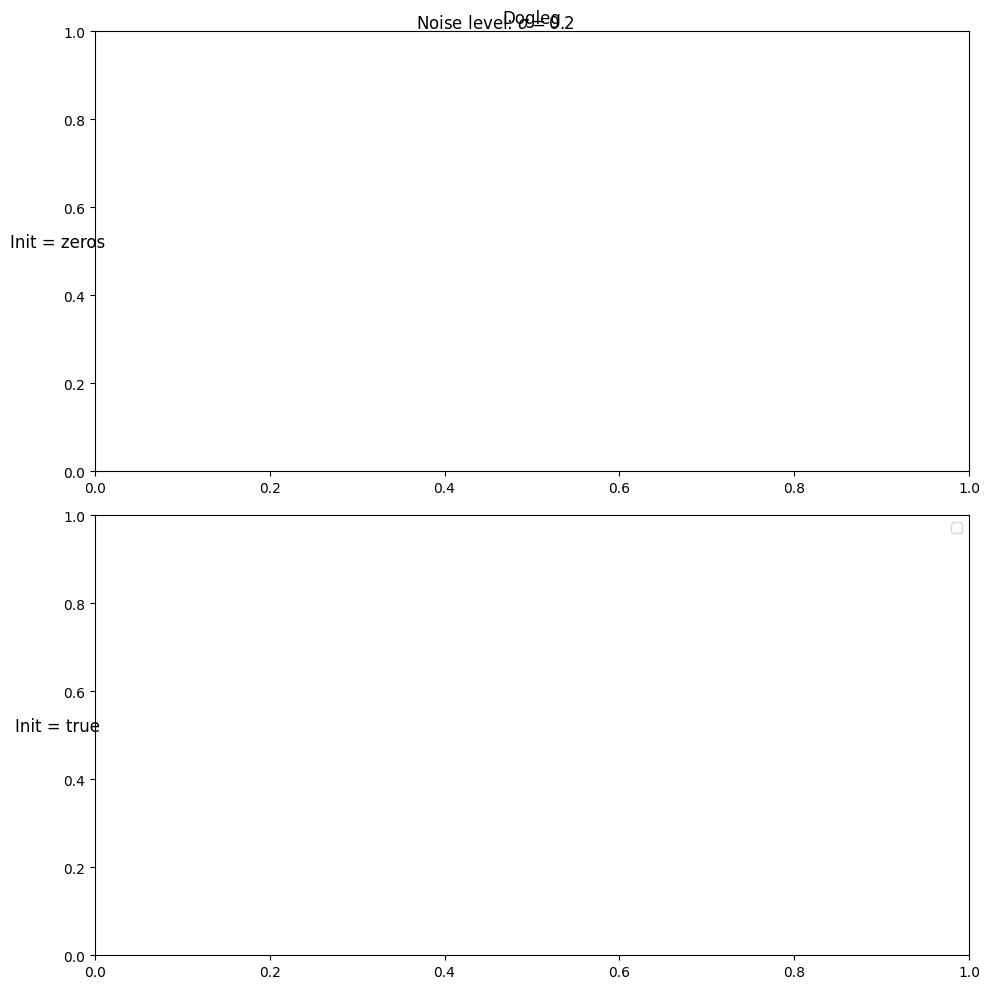

In [55]:
# plot profile for different theta[solver]

fig, axes = plt.subplots(
    len(init_thetas), len(solvers), figsize=(10, 10), squeeze=False
)
rows = [f"Init = {init}" for init in init_thetas.keys()]
cols = [f"{solver}" for solver in solvers.keys()]

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:, 0], rows):
    ax.set_ylabel(row, rotation=0, size="large")

fig.tight_layout()

t_extrapolate = 0  # optionally plot extrapolation
val_t = jnp.linspace(0, Tmax + t_extrapolate, 1000)

# true_logys = solve(parameters=theta, y0=N_0, saveat=dfx.SaveAt(ts=ts))
# true_ys = jnp.exp(true_logys)
# plt.plot(ts, true_ys, "--", alpha=0.8, label="Truth")

for j, solver_type in enumerate(solvers.keys()):
    for i, init_type in enumerate(init_thetas.keys()):
        ax = axes[i, j]
        try:
            sol = sols[solver_type][init_type]
        except KeyError:
            continue  # ignore run that did not converge
        est_logys = solve(theta=sol.value, y0=N_0, saveat=dfx.SaveAt(ts=val_t))
        est_ys = jnp.exp(est_logys)
        ax.plot(val_t, est_ys, alpha=0.5, label=[f"Est {k}" for k in range(Ns)])
        plt.gca().set_prop_cycle(None)
        ax.plot(t_subsample * Tmax, jnp.exp(log_obs_subsample_noisy), "x")
plt.suptitle(rf"Noise level: $\sigma=${noise_level}")

plt.legend()
# fig.tight_layout()

### Conclusion on mean-square solver

Here, the mean squared methodology by autodiff through an ODE solver seems to get stuck in a poor local minima of the objective. Even when initialized with the true $\theta^{\star}$, the estimated $\theta$, $\hat{\theta}$, lead to NaN values in the estimated trajectories. This might be due to the high-noise & low sample size scenario. To go further, one can play with the solver type for the non-linear problem, as well as the `nb_sub_intervals` hyperparameter to sequentially solve the inverse problem on an ever increasing time horizon (an approach recommanded by Patrick Kidger in `optimistix` documentation). In our experience, this does not help in this setting as the sample size is really low, which is a realistic setting in real-world applications where data acquisition is expansive or intrusive.